A notebook to try out the method on chunks from each patient.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path
from IPython.display import display, Markdown

In [3]:
import lfpreg

In [4]:
lfpdata = Path("~/neuropixel/data/LFP_registration_shared/").expanduser()

In [5]:
def showrasters(raw, lfp, csd):
    fig, (aa, ab, ac) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    aa.imshow(raw, aspect=0.25 * raw.shape[1] / raw.shape[0])
    ab.imshow(lfp, aspect=0.25 * lfp.shape[1] / lfp.shape[0])    
    ac.imshow(csd, aspect=0.25 * csd.shape[1] / csd.shape[0])
    aa.set_ylabel("raw lfp")
    ab.set_ylabel("lfp raster")
    ac.set_ylabel("csd raster")
    ac.set_xlabel("time")

In [6]:
subsamp = 5
thresholds = {"pt01": 0.7, "pt02": 0.7, "pt03": 0.7, "pt04": 0.9}

## pt01

orig shape (384, 50000)
sub shape (384, 50000)


averaging each z:   0%|          | 0/192 [00:00<?, ?it/s]

orig shape (384, 50000)
sub shape (384, 50000)


/Users/charlie/neuropixelsLFPregistration/python/pixelCSD.py:35: RuntimeWarning: Mean of empty slice
  mean_CSD = np.nanmean(CSD, 2)


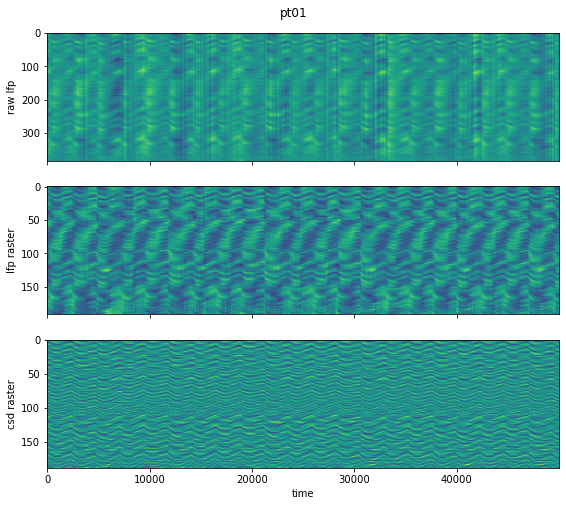

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

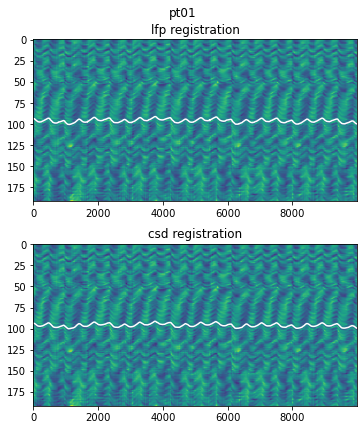

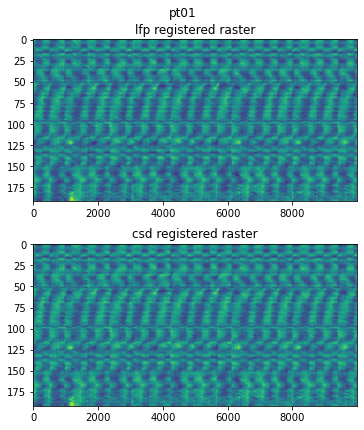

## pt02

orig shape (384, 50000)
sub shape (384, 50000)


averaging each z:   0%|          | 0/192 [00:00<?, ?it/s]

orig shape (384, 50000)
sub shape (384, 50000)


/Users/charlie/neuropixelsLFPregistration/python/pixelCSD.py:35: RuntimeWarning: Mean of empty slice
  mean_CSD = np.nanmean(CSD, 2)


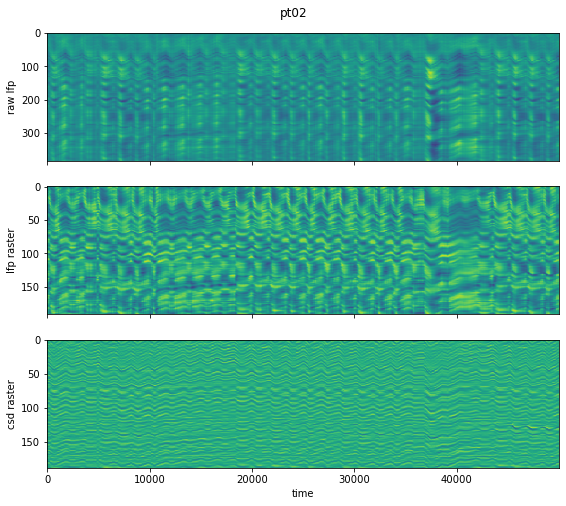

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

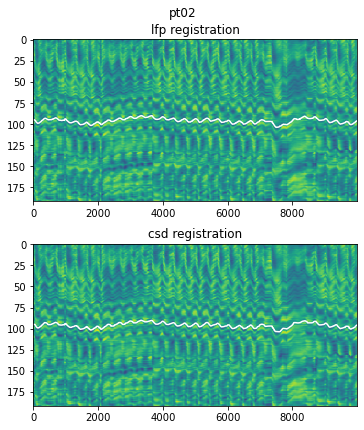

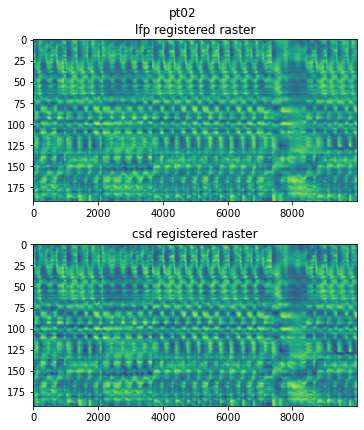

## pt03

orig shape (299, 50000)
sub shape (299, 50000)


averaging each z:   0%|          | 0/150 [00:00<?, ?it/s]

orig shape (299, 50000)
sub shape (299, 50000)


/Users/charlie/neuropixelsLFPregistration/python/pixelCSD.py:35: RuntimeWarning: Mean of empty slice
  mean_CSD = np.nanmean(CSD, 2)


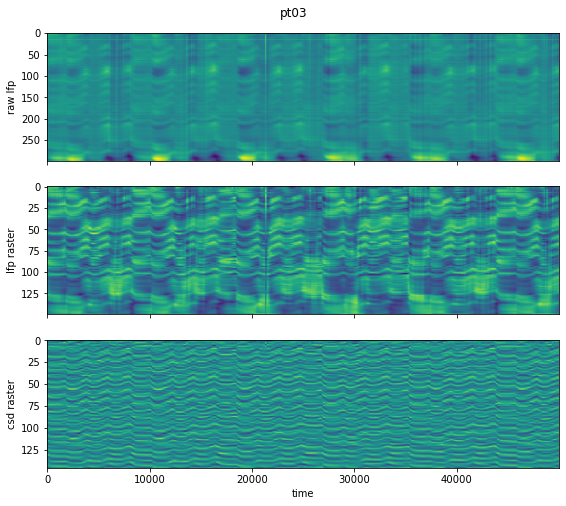

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

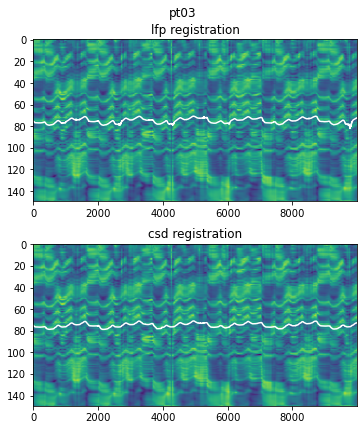

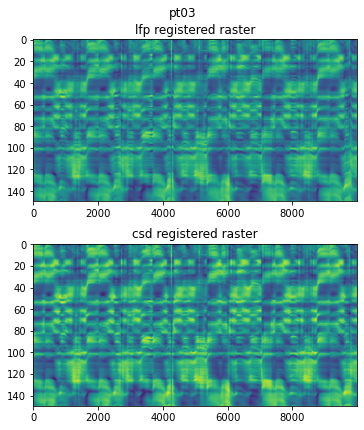

## pt04

orig shape (384, 50000)
sub shape (384, 50000)


averaging each z:   0%|          | 0/192 [00:00<?, ?it/s]

orig shape (384, 50000)
sub shape (384, 50000)


/Users/charlie/neuropixelsLFPregistration/python/pixelCSD.py:35: RuntimeWarning: Mean of empty slice
  mean_CSD = np.nanmean(CSD, 2)


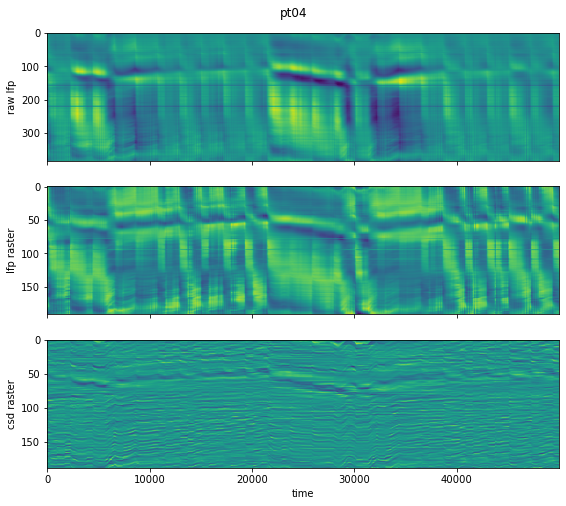

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

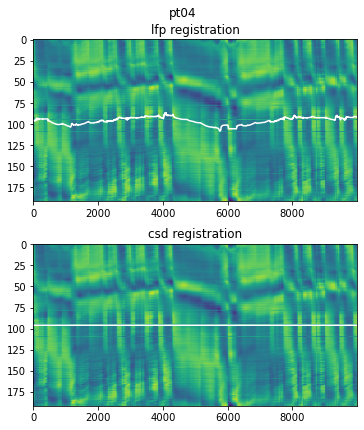

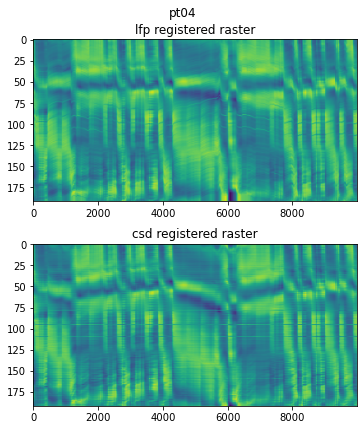

In [7]:
for f in sorted(lfpdata.glob("pt*")):
    lfpf = list(f.glob("*LFP.mat"))[0]
    chanmapf = list(f.glob("*ChanMap.mat"))[0]
    ptstr = lfpf.name.split("_")[0]
    display(Markdown(f"## {ptstr}"))
    
    # load a chunk of data
    chanmap = loadmat(chanmapf)
    geom = np.c_[chanmap["xcoords"], chanmap["ycoords"]]
    lfpf = loadmat(lfpf)
    raw = lfpf["LFPMatrix"]
    chans = slice(0, raw.shape[0])
    if "channels_in_brain" in lfpf:
        chans = (lfpf["channels_in_brain"].astype(int) - 1).ravel()
        chans = slice(chans[0], chans[1])
    geom = geom[chans]
    T = raw.shape[1]
    raw = raw[chans, T//2:T//2 + 50000].copy()
    del lfpf
    
    # raster and CSD
    lfp = lfpreg.lfpraster(raw, geom)
    csd = lfpreg.lfpraster(raw, geom, csd=True)
    showrasters(raw, lfp, csd)
    plt.suptitle(ptstr, y=0.925)
    plt.show()
    
    # register
    p_lfp = lfpreg.register_rigid(lfp[:, ::subsamp], mincorr=thresholds[ptstr])
    p_csd = lfpreg.register_rigid(csd[:, ::subsamp], mincorr=thresholds[ptstr])
    reglfp = lfpreg.rigid_registered_raster(lfp[:, ::subsamp], p_lfp)
    regcsd = lfpreg.rigid_registered_raster(lfp[:, ::subsamp], p_csd)
    
    # plot ps on top of the raster
    fig, (aa, ab) = plt.subplots(2, 1, figsize=(5, 6))
    aa.imshow(lfp[:, ::subsamp], aspect=0.5 * lfp[:, ::subsamp].shape[1] / lfp[:, ::subsamp].shape[0])
    ab.imshow(lfp[:, ::subsamp], aspect=0.5 * lfp[:, ::subsamp].shape[1] / lfp[:, ::subsamp].shape[0])
    aa.plot(lfp.shape[0] / 2 + p_lfp, c="w")
    ab.plot(lfp.shape[0] / 2 + p_csd, c="w")
    aa.set_title("lfp registration")
    ab.set_title("csd registration")
    fig.suptitle(ptstr)
    fig.tight_layout(pad=0.5)
    plt.show()
    
    # plot registered rasters
    fig, (aa, ab) = plt.subplots(2, 1, figsize=(5, 6))
    aa.imshow(reglfp, aspect=0.5 * reglfp.shape[1] / reglfp.shape[0])
    ab.imshow(regcsd, aspect=0.5 * regcsd.shape[1] / regcsd.shape[0])
    aa.set_title("lfp registered raster")
    ab.set_title("csd registered raster")
    fig.suptitle(ptstr)
    fig.tight_layout(pad=0.5)
    plt.show()